In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-comments/students.xlsx
/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Dropout
import tensorflow_hub as hub 

2024-04-18 00:39:48.342034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 00:39:48.342136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 00:39:48.470689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_excel('/kaggle/input/student-comments/students.xlsx')

In [4]:
df.head()

,StudentComments,Sentiment
0,good,positive
1,good,positive
2,teacher,positive
3,friendly teacher but not enough ability to enc...,positive
4,teacher,positive


In [5]:
df.shape

(1048575, 2)

In [6]:
df.isnull().sum()

StudentComments    52
Sentiment           0
dtype: int64

In [7]:
df = df.dropna()

In [8]:
df.isnull().sum()

StudentComments    0
Sentiment          0
dtype: int64

In [9]:
df.shape

(1048523, 2)

<Axes: title={'center': 'Count of Comments by Sentiments'}, xlabel='Sentiment'>

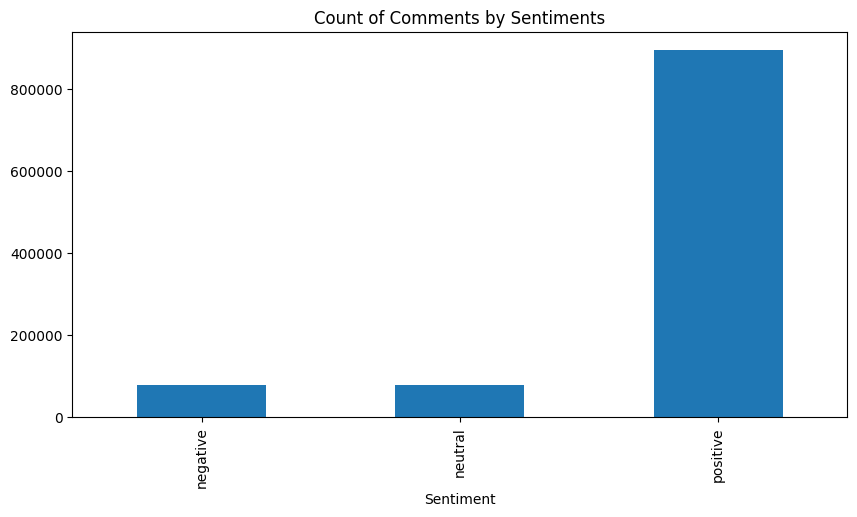

In [10]:
df['Sentiment'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Comments by Sentiments',
          figsize=(10, 5))

In [11]:
value_mapping = {
    'positive': 2,
    'neutral': 1,
    'negative': 0
}

df['Score'] = df['Sentiment'].map(value_mapping)
df = df.drop('Sentiment', axis = 1)

df.head()

,StudentComments,Score
0,good,2
1,good,2
2,teacher,2
3,friendly teacher but not enough ability to enc...,2
4,teacher,2


<Axes: title={'center': 'Count of Comments by Scores'}, xlabel='Score'>

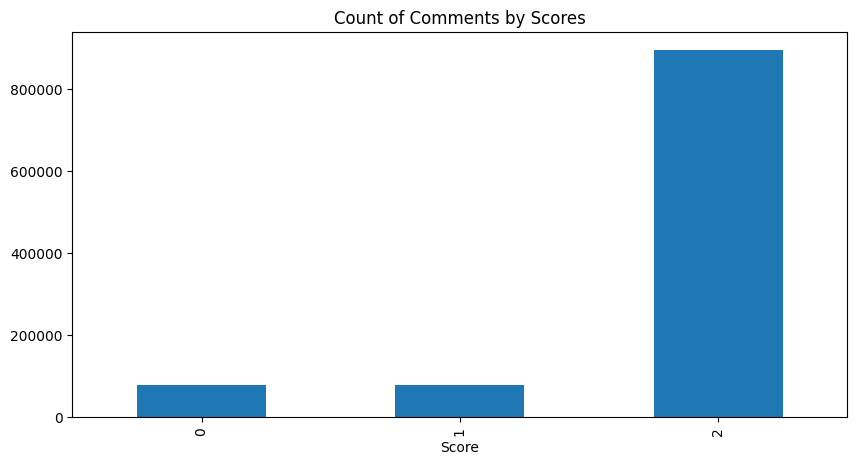

In [12]:
df['Score'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Comments by Scores',
          figsize=(10, 5))

In [13]:
def print_class_proportions(labels):
    # Count the occurrences of each class label
    class_counts = labels.value_counts()
    
    # Calculate proportions
    total_samples = len(labels)
    class_proportions = class_counts / total_samples
    
    # Print class proportions
    print("Class Proportions:")
    for class_label, proportion in class_proportions.items():
        print(f"Class {class_label}: {proportion:.2%}")

In [14]:
def visualize_class_proportions(labels):
    # Count the occurrences of each class label
    class_counts = labels.value_counts()
    
    # Calculate proportions
    class_proportions = class_counts / class_counts.sum()
    
    # Plotting
    plt.figure(figsize=(8, 6))
    class_proportions.plot(kind='bar', color='skyblue')
    plt.title('Proportion of Each Class')
    plt.xlabel('Class')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [15]:
print_class_proportions(df['Score'])

Class Proportions:
Class 2: 85.23%
Class 1: 7.45%
Class 0: 7.32%


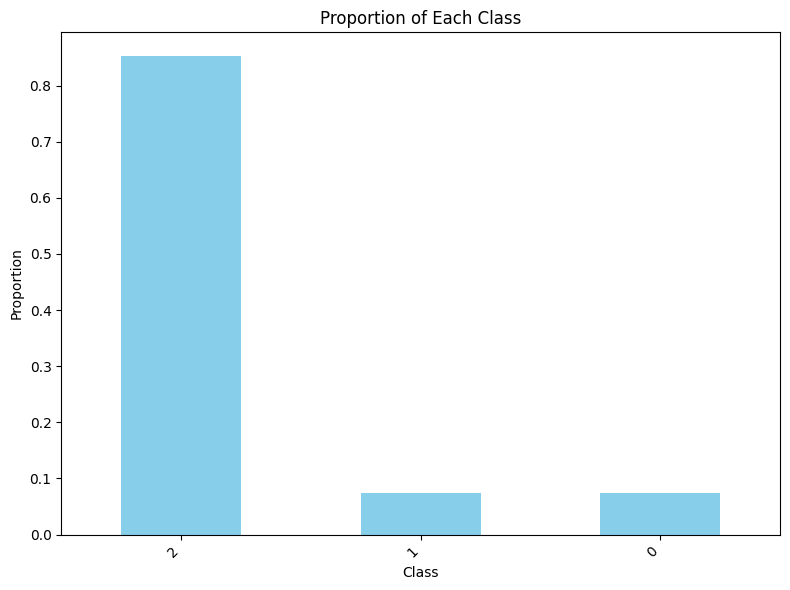

In [16]:
visualize_class_proportions(df['Score'])

In [17]:
df_neg = df[df['Score'] == 0].sample(n=10000)
df_neu = df[df['Score'] == 1].sample(n=10000)
df_pos = df[df['Score'] == 2].sample(n=10000)

df_new = pd.concat([df_neg, df_neu, df_pos]).sample(frac = 1).reset_index(drop=True)

In [18]:
df_new.shape

(30000, 2)

In [19]:
print_class_proportions(df_new['Score'])

Class Proportions:
Class 2: 33.33%
Class 1: 33.33%
Class 0: 33.33%


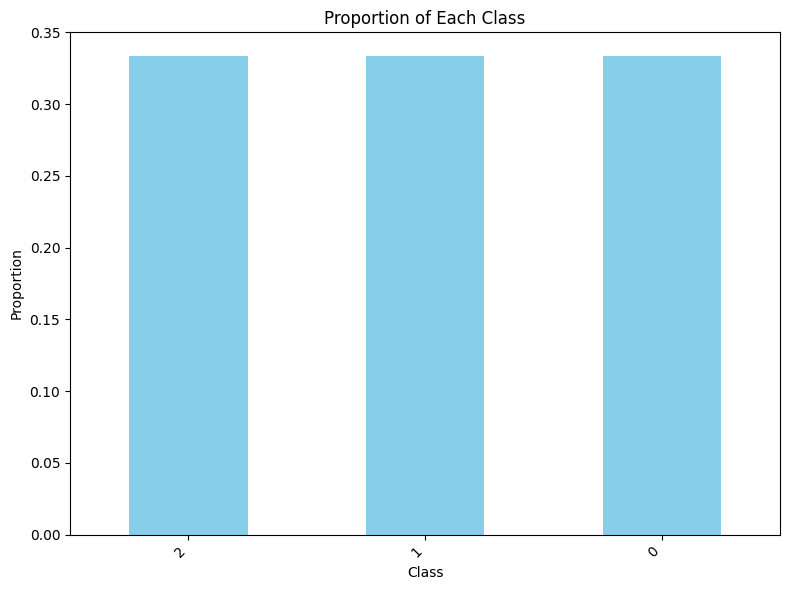

In [20]:
visualize_class_proportions(df_new['Score'])

In [21]:
df_new.head(10)

,StudentComments,Score
0,sir is always good,2
1,good,1
2,she is one of a very good faculties in aiub,2
3,haven't much enjoyed the class.,1
4,moderate,0
5,good,0
6,good,1
7,good,1
8,moderate,1
9,"good faculty.,",2


# Preprocesccing:

In [22]:
import re
from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
df_new['StudentComments'].values[73]

'heis a good scientist than a teacher.'

In [24]:
import re
from string import punctuation

def clean_text(series):
    series = series.str.lower()
    
    # Handle missing values and convert them to empty strings
    series = series.fillna('').astype(str)
    
    series = series.apply(lambda x: ''.join([c for c in x if c not in punctuation]))
    
    # remove numbers
    series = series.apply(lambda x: re.sub(r'\d+', '', x))
    
    # remove extra whitespaces
    series = series.str.strip()
    
    # remove extra whitespaces
    series = series.apply(lambda x: re.sub(' +', ' ', x))
    
    return series

In [25]:
df_new['StudentComments']=clean_text(df_new['StudentComments'])

In [26]:
df_new['StudentComments'].values[73]

'heis a good scientist than a teacher'

In [27]:
# Function to remove stop words:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [28]:
df_new['StudentComments'] = df_new['StudentComments'].apply(remove_stopwords)

In [29]:
df_new['StudentComments'].values[73]

'heis good scientist teacher'

In [30]:
# Function for lemmatization:
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_text)

In [31]:
df_new['StudentComments'] = df_new['StudentComments'].apply(lemmatize_text)

In [32]:
df_new['StudentComments'].values[73]

'heis good scientist teacher'

# Model:

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_new['StudentComments'],df_new['Score'], stratify=df_new['Score'])

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [36]:
X_train.tolist()[0]

'good'

In [37]:
tokenized_data = tokenizer(X_train.tolist(), padding=True,return_tensors='tf', truncation=True, max_length=60)
input_ids = tokenized_data["input_ids"]
attention_mask = tokenized_data["attention_mask"]

In [38]:
X_train.shape,X_test.shape

((22500,), (7500,))

In [39]:
input_ids.shape,attention_mask.shape

(TensorShape([22500, 60]), TensorShape([22500, 60]))

In [40]:
input_ids[0]

<tf.Tensor: shape=(60,), dtype=int32, numpy=
array([ 101, 2204,  102,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)>

In [41]:
# Define the shape and dtype of the empty tensor
shape = 0
dtype = tf.float32

# Create the empty tensor array
empty_tensor = tf.TensorArray(dtype=dtype, size=0, dynamic_size=True)

In [42]:
outputs=[]
for i in range(0,len(input_ids),1):
    batch=input_ids[i:i+1]
    mask=attention_mask[i:i+1]
    embeddings=bert_model(batch, attention_mask=mask)['pooler_output']
    outputs.append(embeddings)
    empty_tensor = empty_tensor.write(empty_tensor.size(), embeddings)
    
result_tensor = empty_tensor.stack()

In [43]:
result_tensor

<tf.Tensor: shape=(22500, 1, 768), dtype=float32, numpy=
array([[[-0.7986119 , -0.18929139,  0.21596459, ...,  0.22309531,
         -0.50096035,  0.8160853 ]],

       [[-0.8506737 , -0.35809296, -0.22282544, ..., -0.01993915,
         -0.6336972 ,  0.86567247]],

       [[-0.769661  , -0.18892217,  0.30264243, ...,  0.21544491,
         -0.50187314,  0.7445595 ]],

       ...,

       [[-0.7986119 , -0.18929139,  0.21596459, ...,  0.22309531,
         -0.50096035,  0.8160853 ]],

       [[-0.70213753, -0.18483205,  0.3311785 , ...,  0.3519296 ,
         -0.50268245,  0.7629364 ]],

       [[-0.8894656 , -0.32699955, -0.05883207, ...,  0.03504434,
         -0.6580179 ,  0.8989022 ]]], dtype=float32)>

# Test embeddings:

In [44]:
test_tokenized_data = tokenizer(X_test.tolist(), padding=True,return_tensors='tf', truncation=True, max_length=60)
test_input_ids = test_tokenized_data["input_ids"]
test_attention_mask = test_tokenized_data["attention_mask"]

In [45]:
shape = 0
dtype = tf.float32

# Create the empty tensor array
empty_tensor2 = tf.TensorArray(dtype=dtype, size=0, dynamic_size=True)

In [46]:
outputs=[]
for i in range(0,len(test_input_ids),1):
    batch=test_input_ids[i:i+1]
    mask=test_attention_mask[i:i+1]
    embeddings=bert_model(batch, attention_mask=mask)['pooler_output']
    outputs.append(embeddings)
    empty_tensor2 = empty_tensor2.write(empty_tensor2.size(), embeddings)
    
test_result_tensor = empty_tensor2.stack()

# Model:

In [47]:
result_tensor = tf.reshape(result_tensor, (-1, result_tensor.shape[2]))
result_tensor.shape

TensorShape([22500, 768])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  96/2250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3955 - loss: 1.1244

I0000 00:00:1713406690.663909      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.3816 - loss: 1.0916 - val_accuracy: 0.4351 - val_loss: 1.0528
Epoch 2/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4503 - loss: 1.0431 - val_accuracy: 0.4578 - val_loss: 1.0293
Epoch 3/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4514 - loss: 1.0329 - val_accuracy: 0.4571 - val_loss: 1.0317
Epoch 4/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4593 - loss: 1.0295 - val_accuracy: 0.4564 - val_loss: 1.0232
Epoch 5/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4540 - loss: 1.0289 - val_accuracy: 0.4622 - val_loss: 1.0329
Epoch 6/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4573 - loss: 1.0247 - val_accuracy: 0.4462 - val_loss: 1.0363
Epoch 7/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4635 - loss: 1.0226 - val_accuracy: 0.4427 - val_loss: 1.0315
Epoch 8/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4629 - loss: 1.0243 - val_accurac

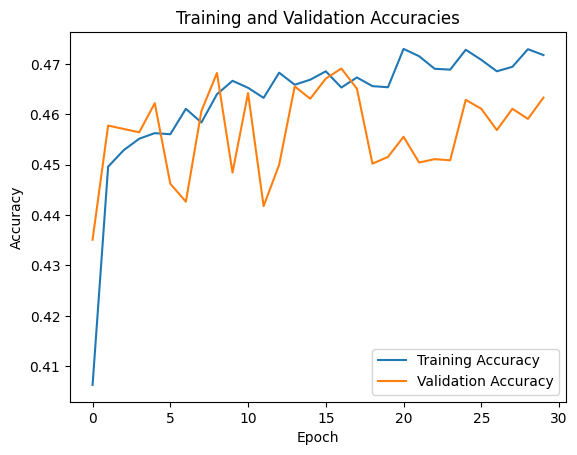

In [48]:
# Define model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(result_tensor.shape[1],)),
    #Dropout(0.5),
    Dense(64, activation='relu'),
    #Dropout(0.5),
    Dense(16, activation='relu'),

    Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(result_tensor, y_train, epochs=30, batch_size=8, validation_split=.2)


# Optionally, you can plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

In [49]:
test_result_tensor = tf.reshape(test_result_tensor, (-1, test_result_tensor.shape[2]))
test_result_tensor.shape

TensorShape([7500, 768])

In [50]:
X_train=result_tensor.numpy()
X_test=test_result_tensor.numpy()

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


# Step 2: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train and evaluate different classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Neural Network': MLPClassifier()
}

results = {}

for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1
    }
    
    # Print a classification report
    print(f"Classifier: {name}")
    print(classification_report(y_test, y_pred))
    print('-' * 30)

# Compare results across different classifiers
print("Comparison of different classifiers:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print('-' * 30)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: Logistic Regression
              precision    recall  f1-score   support

           0       0.58      0.46      0.52      2500
           1       0.39      0.48      0.43      2500
           2       0.49      0.48      0.49      2500

    accuracy                           0.48      7500
   macro avg       0.49      0.48      0.48      7500
weighted avg       0.49      0.48      0.48      7500

------------------------------
Classifier: Support Vector Machine
              precision    recall  f1-score   support

           0       0.57      0.51      0.53      2500
           1       0.40      0.46      0.43      2500
           2       0.50      0.48      0.49      2500

    accuracy                           0.48      7500
   macro avg       0.49      0.48      0.48      7500
weighted avg       0.49      0.48      0.48      7500

------------------------------
Classifier: Random Forest
              precision    recall  f1-score   support

           0       0.54     

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# Keras Embeddings:

In [52]:
# from keras.preprocessing.text import one_hot
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.models import Model

In [53]:
# A function to create our padded orders:
def ready_to_be_embedded(text):
    
    # Identify our vocab size:
    vocab_size = 5000
    
    # One hot representation:
    onehot_represent = [one_hot(word, vocab_size) for word in text]
    
    # So, We will pad all comments to have the length of the maximum comment:
    padded_comments = pad_sequences(onehot_represent, maxlen= 1, padding= 'post')
    
    return padded_comments

In [54]:
padded_comments = df_new['StudentComments'].apply(ready_to_be_embedded)

In [55]:
def flatten_extend(lists):
    flat_list = []
    for item in lists:
        flat_list.extend(item)
    return flat_list

In [56]:
flatten_padded_comments = padded_comments.apply(flatten_extend)

In [57]:
nn_input = pad_sequences(flatten_padded_comments, maxlen= 60, padding= 'post')

In [58]:
nn_input[4]

array([2581,  293, 3436, 4566,  954,  524, 1028, 4566,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [59]:
nn_input[73]

array([ 126, 4566,  349, 1068,    0, 3447,  293,  293, 3436,    0, 1068,
       3827,  349, 4566, 1980, 1028,  349, 1068, 1028,    0, 1028, 4566,
        524, 3827,  126, 4566,  954,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [60]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(nn_input,df_new['Score'], stratify=df_new['Score'])

In [61]:
# Define model architecture
model = Sequential([
    Embedding(5000, 8),
    Flatten(),
    Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=.2)

Epoch 1/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.4089 - loss: 1.0702 - val_accuracy: 0.4507 - val_loss: 1.0336
Epoch 2/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4396 - loss: 1.0378 - val_accuracy: 0.4489 - val_loss: 1.0342
Epoch 3/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4678 - loss: 1.0249 - val_accuracy: 0.4569 - val_loss: 1.0309
Epoch 4/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4629 - loss: 1.0183 - val_accuracy: 0.4538 - val_loss: 1.0326
Epoch 5/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4776 - loss: 1.0049 - val_accuracy: 0.4469 - val_loss: 1.0321
Epoch 6/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4738 - loss: 1.0098 - val_accuracy: 0.4409 - val_loss: 1.0363
Epoch 7/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4824 - loss: 0.9972 - val_accuracy: 0.4547 - val_loss: 1.0427
Epoch 8/30
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4711 - loss: 1.0049 - 

In [62]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


# Step 2: Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 3: Train and evaluate different classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Neural Network': MLPClassifier()
}

results = {}

for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    
    # Evaluate performance
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='micro')
    
    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1
    }
    
    # Print a classification report
    print(f"Classifier: {name}")
    print(classification_report(y_test, y_pred))
    print('-' * 30)

# Compare results across different classifiers
print("Comparison of different classifiers:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print('-' * 30)

Classifier: Logistic Regression
              precision    recall  f1-score   support

           0       0.48      0.45      0.46      2500
           1       0.38      0.41      0.39      2500
           2       0.41      0.40      0.40      2500

    accuracy                           0.42      7500
   macro avg       0.42      0.42      0.42      7500
weighted avg       0.42      0.42      0.42      7500

------------------------------
Classifier: Support Vector Machine
              precision    recall  f1-score   support

           0       0.49      0.48      0.49      2500
           1       0.40      0.51      0.45      2500
           2       0.49      0.37      0.42      2500

    accuracy                           0.45      7500
   macro avg       0.46      0.45      0.45      7500
weighted avg       0.46      0.45      0.45      7500

------------------------------
Classifier: Random Forest
              precision    recall  f1-score   support

           0       0.54     

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# TextBlob:

In [63]:
from textblob import TextBlob

In [64]:
# Create a function to get the subjectivity:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity:
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [65]:
#Create two new columns ‘Subjectivity’ & ‘Polarity’
df_new['TextBlob_Subjectivity'] = df_new['StudentComments'].apply(getSubjectivity)
df_new['TextBlob_Polarity'] = df_new['StudentComments'].apply(getPolarity)

In [66]:
df_new.head(10)

,StudentComments,Score,TextBlob_Subjectivity,TextBlob_Polarity
0,sir always good,2,0.6,0.7
1,good,1,0.6,0.7
2,one good faculty aiub,2,0.6,0.7
3,have not much enjoy class,1,0.5,-0.2
4,moderate,0,0.7,0.0
5,good,0,0.6,0.7
6,good,1,0.6,0.7
7,good,1,0.6,0.7
8,moderate,1,0.7,0.0
9,good faculty,2,0.6,0.7


In [67]:
def getScore(polarity):
    if polarity < 0:
        return 0
    elif polarity == 0:
        return 1
    else:
        return 2

In [68]:
TextBlob_Scores = df_new['TextBlob_Polarity'].apply(getScore)

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [70]:
# find number of accurate predictions
accurate_predictions = accuracy_score(df_new['Score'], TextBlob_Scores)
print("The percentage of accurate predictions is: ", accurate_predictions)

The percentage of accurate predictions is:  0.41986666666666667


In [71]:
# Creating a classification report:
print(classification_report(df_new['Score'], TextBlob_Scores))

              precision    recall  f1-score   support

           0       0.67      0.20      0.31     10000
           1       0.34      0.19      0.24     10000
           2       0.41      0.87      0.55     10000

    accuracy                           0.42     30000
   macro avg       0.47      0.42      0.37     30000
weighted avg       0.47      0.42      0.37     30000



In [72]:
# Creating a confusion matrix,which compares the y_test and y_pred:
cm = confusion_matrix(df_new['Score'], TextBlob_Scores)

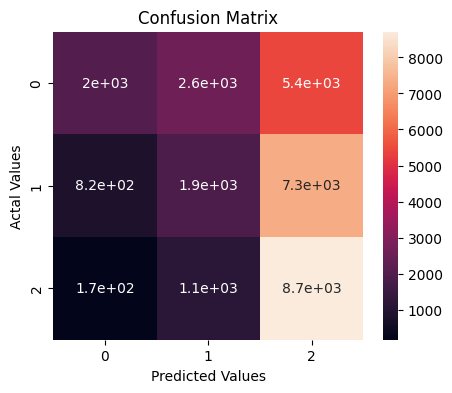

In [73]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2'], 
                     columns = ['0','1','2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

# VADER:

In [74]:
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [75]:
def getVader(text):
    return analyzer.polarity_scores(text)

In [76]:
vaderDict = df_new['StudentComments'].apply(getVader)

In [77]:
vaderDict[:10]

0    {'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...
1    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
2    {'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'comp...
3    {'neg': 0.396, 'neu': 0.604, 'pos': 0.0, 'comp...
4    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
5    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
6    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
7    {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'comp...
Name: StudentComments, dtype: object

In [78]:
print(vaderDict[10])

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}


In [79]:
print(vaderDict[55])

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}


In [80]:
def getVaderScores (polarity):
    polarity.pop('compound')
    score = max(polarity, key = polarity.get)
    
    if score == 'neg':
        return 0
    elif score == 'neu':
        return 1
    else:
        return 2

In [81]:
Vader_Scores = vaderDict.apply(getVaderScores)

In [82]:
Vader_Scores[:10]

0    2
1    2
2    1
3    1
4    1
5    2
6    2
7    2
8    1
9    2
Name: StudentComments, dtype: int64

In [83]:
# find number of accurate predictions
accurate_predictions = accuracy_score(df_new['Score'], Vader_Scores)
print("The percentage of accurate predictions is: ", accurate_predictions)

The percentage of accurate predictions is:  0.40823333333333334


In [84]:
# Creating a classification report:
print(classification_report(df_new['Score'], Vader_Scores))

              precision    recall  f1-score   support

           0       0.65      0.18      0.28     10000
           1       0.30      0.20      0.24     10000
           2       0.41      0.85      0.55     10000

    accuracy                           0.41     30000
   macro avg       0.45      0.41      0.36     30000
weighted avg       0.45      0.41      0.36     30000



In [85]:
# Creating a confusion matrix,which compares the y_test and y_pred:
cm = confusion_matrix(df_new['Score'], Vader_Scores)

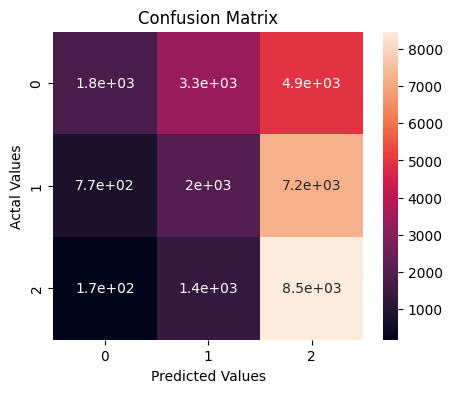

In [86]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['0','1','2'], 
                     columns = ['0','1','2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()